![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Daily Correlation
</b>
</span>

---
**Notebook version**: `1` (18 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **Description**

- Calculate daily correlation between two time series.
- In example (1), the daily correlation between observed global radiation `Rg_f` (observed value) and potential radiation `SW_IN_POT` (calculated value) is investigated.
    - Both variables are expected to be highly correlated.
    - If correlations are low this could be indivative of problems with the sensor or other issues, e.g., a timestamp shift.
- In example (2), the daily correlation between observed global radiation `Rg_f` (observed value) and air temperature `Tair_f` (observed value) is investigated.

</br>

# **Imports**

In [1]:
import importlib.metadata
from datetime import datetime
import pandas as pd
import warnings
warnings.simplefilter("ignore", UserWarning)
from diive.pkgs.analyses.correlation import daily_correlation
from diive.configs.exampledata import load_exampledata_parquet  # Example data
from diive.pkgs.createvar.potentialradiation import potrad  # Function to calculate potential radiation
from diive.core.plotting.heatmap_xyz import HeatmapPivotXYZ  # Heatmap plot
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.71.2


In [2]:
help(daily_correlation)

Help on function daily_correlation in module diive.pkgs.analyses.correlation:

daily_correlation(s1: pandas.core.series.Series, s2: pandas.core.series.Series, mincorr: float = 0.8, showplot: bool = False) -> pandas.core.series.Series
    Calculate daily correlation between two time series.
    
    Args:
        s1: any time series, timestamp must overlap with *s2*
        s2: any time series, timestamp must overlap with *s1*
        mincorr: minimum absolute correlation, only relevant when *showplot=True*,
            must be between -1 and 1 (inclusive)
            Example: with *0.8* all correlations between -0.8 and +0.8 are considered low,
            and all correlations smaller than -0.8 and higher than +0.8 are considered high.
        showplot: if *True*, show plot of results
    
    Returns:
        series with correlations for each day



</br>

# **Load example data**

In [3]:
data_df = load_exampledata_parquet()
data_df = data_df.loc[data_df.index.year == 2022].copy()  # Use only year 2022
data_df

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.052 seconds). Detected time resolution of <30 * Minutes> / 30T 


,ET_f,GPP_CUT_16_f,GPP_CUT_84_f,GPP_CUT_REF_f,GPP_CUT_REF_fqc,GPP_DT_CUT_16,GPP_DT_CUT_84,GPP_DT_CUT_REF,GPP_DT_CUT_REF_SD,LE_f,LE_orig,LW_IN,NEE_CUT_16_f,NEE_CUT_16_orig,NEE_CUT_84_f,...,Reco_CUT_REF,Reco_DT_CUT_16,Reco_DT_CUT_84,Reco_DT_CUT_REF,Reco_DT_CUT_REF_SD,Rg_f,Rg_orig,RH,SWC_FF0_0.15_1,Tair_f,Tair_orig,Ustar_CUT_REF_fqc,Ustar_CUT_REF_Thres,VPD_f,VPD_orig
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:15:00,0.176184,1.032784,0.590684,0.816263,1.0,0.0,0.0,0.0,0.0,7.908732,NaN,240.852214,-0.480587,NaN,0.299004,...,0.600019,1.350028,2.147692,2.222472,5.190969,0.0,0.0,42.030000,27.288090,3.976667,3.976667,4.0,0.287644,4.709298,4.709298
2022-01-01 00:45:00,0.170491,1.033352,0.592527,0.817408,1.0,0.0,0.0,0.0,0.0,7.652814,NaN,240.911549,-0.480587,NaN,0.299004,...,0.601163,1.362418,2.149259,2.243701,5.205988,0.0,0.0,41.526667,27.287990,4.026667,4.026667,4.0,0.287644,4.766964,4.766964
2022-01-01 01:15:00,0.151217,1.015268,0.558311,0.797319,1.0,0.0,0.0,0.0,0.0,6.790372,NaN,240.549308,-0.480587,NaN,0.299004,...,0.581075,1.319970,2.075222,2.179656,5.024455,0.0,0.0,43.363333,27.288220,3.603333,3.603333,4.0,0.287644,4.481237,4.481237
2022-01-01 01:45:00,0.139777,0.782353,0.527337,0.779048,1.0,0.0,0.0,0.0,0.0,6.278959,NaN,239.717064,-0.264159,NaN,0.299004,...,0.562804,1.281783,2.007783,2.122008,4.859881,0.0,0.0,45.396667,27.288143,3.213333,3.213333,4.0,0.287644,4.202590,4.202590
2022-01-01 02:15:00,0.133699,0.776544,0.516904,0.772912,1.0,0.0,0.0,0.0,0.0,6.006607,NaN,239.508473,-0.264159,NaN,0.299004,...,0.556668,1.274704,1.983586,2.112793,4.807471,0.0,0.0,45.966667,27.289983,3.096667,3.096667,4.0,0.287644,4.124407,4.124407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,-0.016362,0.372884,0.203050,0.599719,1.0,0.0,0.0,0.0,0.0,-0.734820,-0.73482,230.498649,0.628517,NaN,1.252629,...,1.823971,2.568115,1.221357,1.031544,0.758554,0.0,0.0,71.790000,19.571710,3.463333,3.463333,0.0,0.287644,2.210036,2.210036
2022-12-31 22:15:00,0.105363,-2.379376,0.893736,-1.433363,0.0,0.0,0.0,0.0,0.0,4.723780,4.72378,231.787766,3.517950,3.51795,0.802932,...,2.084587,2.959299,1.355551,1.173899,0.837950,0.0,0.0,62.626667,19.577070,5.283333,5.283333,0.0,0.287644,3.327497,3.327497
2022-12-31 22:45:00,0.219531,-0.515191,0.925969,-0.305039,1.0,0.0,0.0,0.0,0.0,9.839938,NaN,237.303455,1.672768,NaN,0.802932,...,2.119267,3.038077,1.366567,1.198887,0.857108,0.0,0.0,61.746667,19.588683,5.536667,5.536667,0.0,0.287644,3.466505,3.466505


In [4]:
rg_series = data_df['Rg_f'].copy()  # Observed radiation time series for example (1) and (2)
ta_series = data_df['Tair_f'].copy()  # Observed air temperature time series for example (2)
nee_series = data_df['NEE_CUT_REF_f'].copy()  # Observed net ecosystem exhange of CO2 time series from eddy covariance measurements for example (3)
print("Time series of global radiation in W m-2:")
display(rg_series)
print("\n\nTime series of air temperature in °C:")
display(ta_series)
print("\n\nTime series of net ecosystem exchange of CO2 in µmol CO2 m-2 s-1:")
display(nee_series)

Time series of global radiation in W m-2:


TIMESTAMP_MIDDLE
2022-01-01 00:15:00    0.0
2022-01-01 00:45:00    0.0
2022-01-01 01:15:00    0.0
2022-01-01 01:45:00    0.0
2022-01-01 02:15:00    0.0
                      ... 
2022-12-31 21:45:00    0.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    0.0
2022-12-31 23:15:00    0.0
2022-12-31 23:45:00    0.0
Freq: 30T, Name: Rg_f, Length: 17520, dtype: float64



Time series of air temperature in °C:


TIMESTAMP_MIDDLE
2022-01-01 00:15:00    3.976667
2022-01-01 00:45:00    4.026667
2022-01-01 01:15:00    3.603333
2022-01-01 01:45:00    3.213333
2022-01-01 02:15:00    3.096667
                         ...   
2022-12-31 21:45:00    3.463333
2022-12-31 22:15:00    5.283333
2022-12-31 22:45:00    5.536667
2022-12-31 23:15:00    4.963333
2022-12-31 23:45:00    6.490000
Freq: 30T, Name: Tair_f, Length: 17520, dtype: float64



Time series of net ecosystem exchange of CO2 in µmol CO2 m-2 s-1:


TIMESTAMP_MIDDLE
2022-01-01 00:15:00   -0.216244
2022-01-01 00:45:00   -0.216244
2022-01-01 01:15:00   -0.216244
2022-01-01 01:45:00   -0.216244
2022-01-01 02:15:00   -0.216244
                         ...   
2022-12-31 21:45:00    1.224251
2022-12-31 22:15:00    3.517950
2022-12-31 22:45:00    2.424306
2022-12-31 23:15:00    1.016594
2022-12-31 23:45:00    2.280901
Freq: 30T, Name: NEE_CUT_REF_f, Length: 17520, dtype: float64

In [5]:
# Calculate potential radiation SW_IN_POT to use as reference in example (1)
reference = potrad(timestamp_index=rg_series.index,
                   lat=47.286417,
                   lon=7.733750,
                   utc_offset=1)
reference

TIMESTAMP_MIDDLE
2022-01-01 00:15:00    0.0
2022-01-01 00:45:00    0.0
2022-01-01 01:15:00    0.0
2022-01-01 01:45:00    0.0
2022-01-01 02:15:00    0.0
                      ... 
2022-12-31 21:45:00    0.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    0.0
2022-12-31 23:15:00    0.0
2022-12-31 23:45:00    0.0
Freq: 30T, Name: SW_IN_POT, Length: 17520, dtype: float64

</br>

# (1) **Calculate daily correlation between `Rg_f` and `SW_IN_POT`**

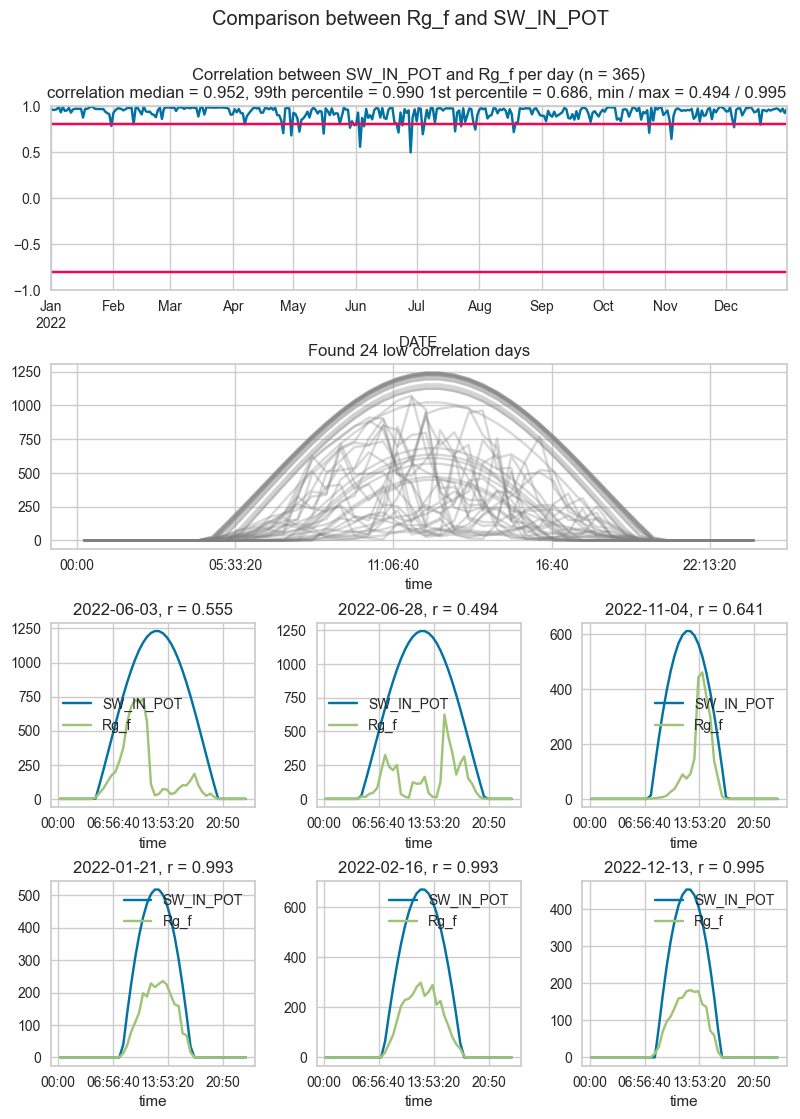

In [6]:
daycorrs = daily_correlation(
    s1=rg_series,
    s2=reference,
    mincorr=0.8,
    showplot=True
)

In [7]:
# All daily correlations
daycorrs

DATE
2022-01-01    0.967678
2022-01-02    0.954463
2022-01-03    0.955140
2022-01-04    0.962414
2022-01-05    0.987641
                ...   
2022-12-27    0.960270
2022-12-28    0.936301
2022-12-29    0.967984
2022-12-30    0.920200
2022-12-31    0.962476
Freq: D, Name: daycorrs, Length: 365, dtype: float64

</br>

# (2) **Calculate daily correlation between `Tair_f` and `Rg_f`**

In [8]:
daycorrs = daily_correlation(
    s1=ta_series,
    s2=rg_series
)

In [9]:
# All daily correlations
daycorrs

DATE
2022-01-01    0.854444
2022-01-02    0.828603
2022-01-03    0.754205
2022-01-04    0.729150
2022-01-05    0.020353
                ...   
2022-12-27    0.270992
2022-12-28    0.578540
2022-12-29    0.475498
2022-12-30    0.294100
2022-12-31    0.705952
Freq: D, Name: daycorrs, Length: 365, dtype: float64

</br>

# (3) **Calculate daily correlation between `Tair_f` and `NEE_CUT_REF_f`**

In [10]:
daycorrs = daily_correlation(
    s1=ta_series,
    s2=nee_series,    
    showplot=False
)

In [11]:
# All daily correlations
daycorrs

DATE
2022-01-01    0.588815
2022-01-02    0.206878
2022-01-03   -0.066571
2022-01-04    0.095548
2022-01-05   -0.237823
                ...   
2022-12-27   -0.305038
2022-12-28   -0.248758
2022-12-29   -0.118073
2022-12-30   -0.291628
2022-12-31   -0.370039
Freq: D, Name: daycorrs, Length: 365, dtype: float64

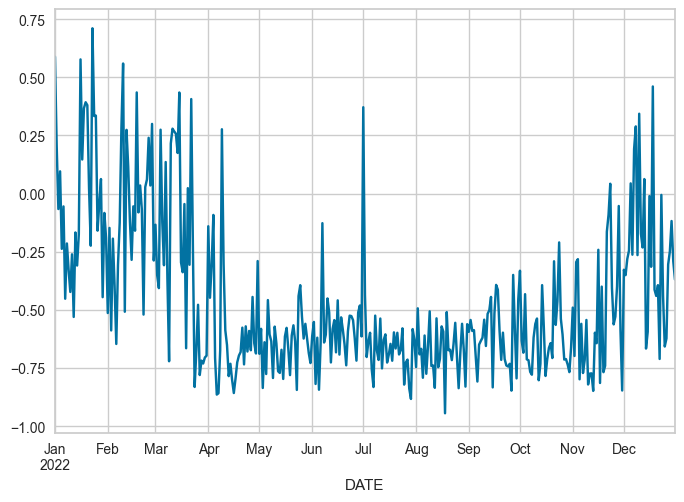

In [12]:
daycorrs.plot();

</br>

# **End of notebook**

In [13]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-03-18 01:35:53
